Using sklearn to perform MNIST classification task

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
import numpy as np

Combine the training, testing and validation sets

In [9]:
X = np.concatenate([mnist.train.images, mnist.test.images, mnist.validation.images])
y = np.concatenate([mnist.train.labels, mnist.test.labels, mnist.validation.labels])
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

Visualize certain digits

In [10]:
some_digit = X[10000].reshape(28, 28)

In [11]:
% matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [12]:
#plt.imshow(some_digit, cmap = matplotlib.cm.binary, interpolation="nearest")
#plt.axis("off")

For classificaion test, make sure the training, testing and validation sets are seperated. Make sure to shuffle the data

In [13]:
shuffle_idx = np.random.permutation(55000)
X_train, y_train = X_train[shuffle_idx, :], y_train[shuffle_idx]

### Train a binary classifier
Identify if the number is 5 or not

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

First thing to test is the SGD classifier

In [15]:
from sklearn.linear_model import SGDClassifier

In [16]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [17]:
sgd_clf.predict(some_digit.reshape(1, 784))

array([ True], dtype=bool)

###  Performace measure

1, Implementing cross-validation

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [19]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold =(y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.96623759136
0.968090328915
0.969726722304


In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.96623759,  0.96809033,  0.96972672])

For classification task, accuracy is not generally a good measure.This is especially the case when the data is skewed.

### Confusion matrix

A better way to evaluate the performance of a classifier is to see how frequent it misclassified A into B.

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[49265,   748],
       [ 1011,  3976]])

The most two useful metrics from confusion matrix is precision and recall(sensitivity). Precision is defined as true positive among all the considered positives. Recall(sensitivity) is defined as true positive among all the positives.

In [23]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8416596105
0.797272909565


### Multiclass classification

Beside algorithms that could directly perform multiclass classfication, including random forest classfier or Naive Bayes classification, we could also use SGDclassifier in combination of one v.s. rest or one v.s. one classification.

In [24]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [25]:
sgd_clf.predict([some_digit.reshape(784)])

array([5], dtype=uint8)

In [26]:
some_digit_scores = sgd_clf.decision_function([some_digit.reshape(784)])

In [27]:
np.argmax(some_digit_scores)

5

In [28]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False),
          n_jobs=1)

In [29]:
ovo_clf.predict([some_digit.reshape(784)])

array([5], dtype=uint8)

In [30]:
len(ovo_clf.estimators_)   # One classifier to each combination of class

45

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict(some_digit.reshape(1,784))

array([5], dtype=uint8)

In [32]:
forest_clf.predict_proba([some_digit.reshape(784)])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

Evaluate the different classifiers with cross validation

In [33]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86753558,  0.87928871,  0.89181669])

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90789115,  0.91163476,  0.91025641])

In [37]:
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [41]:
conf_mx = confusion_matrix(y_train, y_train_predict)

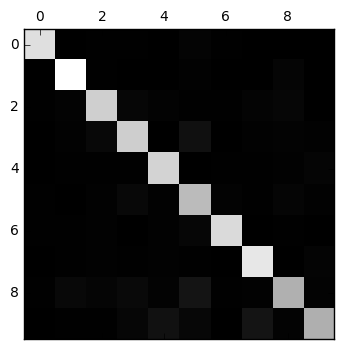

In [43]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

To focus more on the error, we shoudld first set convert the absolute numbers into error rate. We then need to set the diagonal to zero.

In [83]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

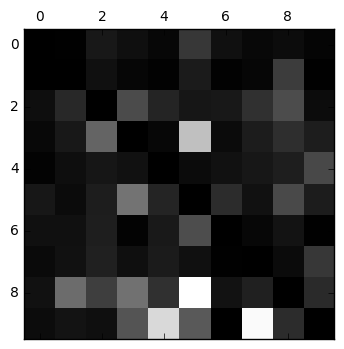

In [86]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

(10, 10)